# Default risk rating in non profit microfinance : case of non profit orgnisation KIVA

The main purpose of this study is to predict the defaut risk of the client of the **non profit organisation Kiva**. To archieve this goal we will use some predictions models to find the score of each lender. The following step will be use to build our models :
# I) Explonatory data analysis
### a) Merge the dataset
### b) Univariate analysis
### c) Bivariate analysis
### d) Multivariate analysis
# II) Modelisation
### a) Resampling our dataset
### b) Selection of the variable
### c) Implementation

# Explonatory data analysis
As define previously, we will first start to merging our datasets. Before doing this we will install all the libraries.
### a) Merge the dataset

In [63]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
from sklearn.impute import KNNImputer
import pycountry_convert as pc
drive.mount('/content/drive')



from langdetect import detect

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Now we have install the librabries, We will upload our datasets. We have two datasets :
> - Loan dataset : contain some basics information in the lender
- Description dataset : contain the informations which are related to the description of each loan.

In [64]:
#Detection of the dataset'encoding
import chardet

#Loan dataset
with open("/content/drive/My Drive/Stat_App/loans.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.7291077209623456, 'encoding': 'ISO-8859-1', 'language': ''}

In [65]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
#Description dataset
with open("/content/drive/My Drive/Stat_App/description.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [67]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [68]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [69]:
db_desc.head(2)

,id,loan_name,description,description_translated,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,156,Marks Antonio,Through my association with the local elementa...,NaN,Purchase of tools and materials to full first ...,NI,Nicaragua,Managua,standard,NaN,5,6,1,NaN,Marks Antonio,male,true,monthly,field_partner
1,173,NaN,NaN,NaN,NaN,GZ,Gaza,NaN,standard,NaN,2,12,7,user_favorite,NaN,NaN,NaN,monthly,field_partner


In [70]:
loan.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,362.0,50,05/06/2006,50,16/09/2006,12.150833,-86.268333


Now have have the quick look of our datasets, we are going to start the pretraitement for the dataset **loans** which contain many duplicates observations.
* Drop dupplicates observations

In [71]:
## Number of dupplicates values (loan database)
loan.duplicated(subset=['id']).sum()

37177

In [72]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [73]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.reset_index(inplace=True)
data = data.drop('index',axis=1)
data.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,en,defaulted,600,NaN,Construction,Construction,NaN,Gaza,Rafah,town,2,Mansour,Al Nawajha,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


In [74]:
print('The shape of our new dataset without duplicates : ', data.shape)

The shape of our new dataset without duplicates :  (5004, 42)


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5004 non-null   object 
 1   description.languages                   3267 non-null   object 
 2   status                                  5004 non-null   object 
 3   funded_amount                           5004 non-null   object 
 4   paid_amount                             4904 non-null   object 
 5   activity                                5004 non-null   object 
 6   sector                                  5004 non-null   object 
 7   location.country_code                   4962 non-null   object 
 8   location.country                        5004 non-null   object 
 9   location.town                           4871 non-null   object 
 10  location.geo.level                      5002 non-null   obje

This caption show that our loan dataset contains many variables which have no observations. These variables will be removed in our dataset, we are going keep only those which have the information.

In [76]:
#list of unuseful variables
useless = ['description.languages','activity','partner_id','location.geo.level','location.town','location.country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]

In [77]:
data = data.drop(useless, axis = 1)
data.shape

(5004, 33)

In [78]:
data.head(2)

,id,status,funded_amount,paid_amount,sector,location.country,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,paid,500,500,Construction,Nicaragua,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,defaulted,600,NaN,Construction,Gaza,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


* Merge dataset laon with description

*These* datasets do not have the same size we are going to merge them.

In [79]:
resul = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [80]:
resul.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'location.country', 'borrowers.gender', 'borrowers.pictured',
       'terms.disbursal_amount', 'terms.disbursal_currency',
       'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'tags', 'borrow

After merging our datasets, we are now going to look for the missing values. This analysis will help us to see whether it is good or not to merge the dataset.

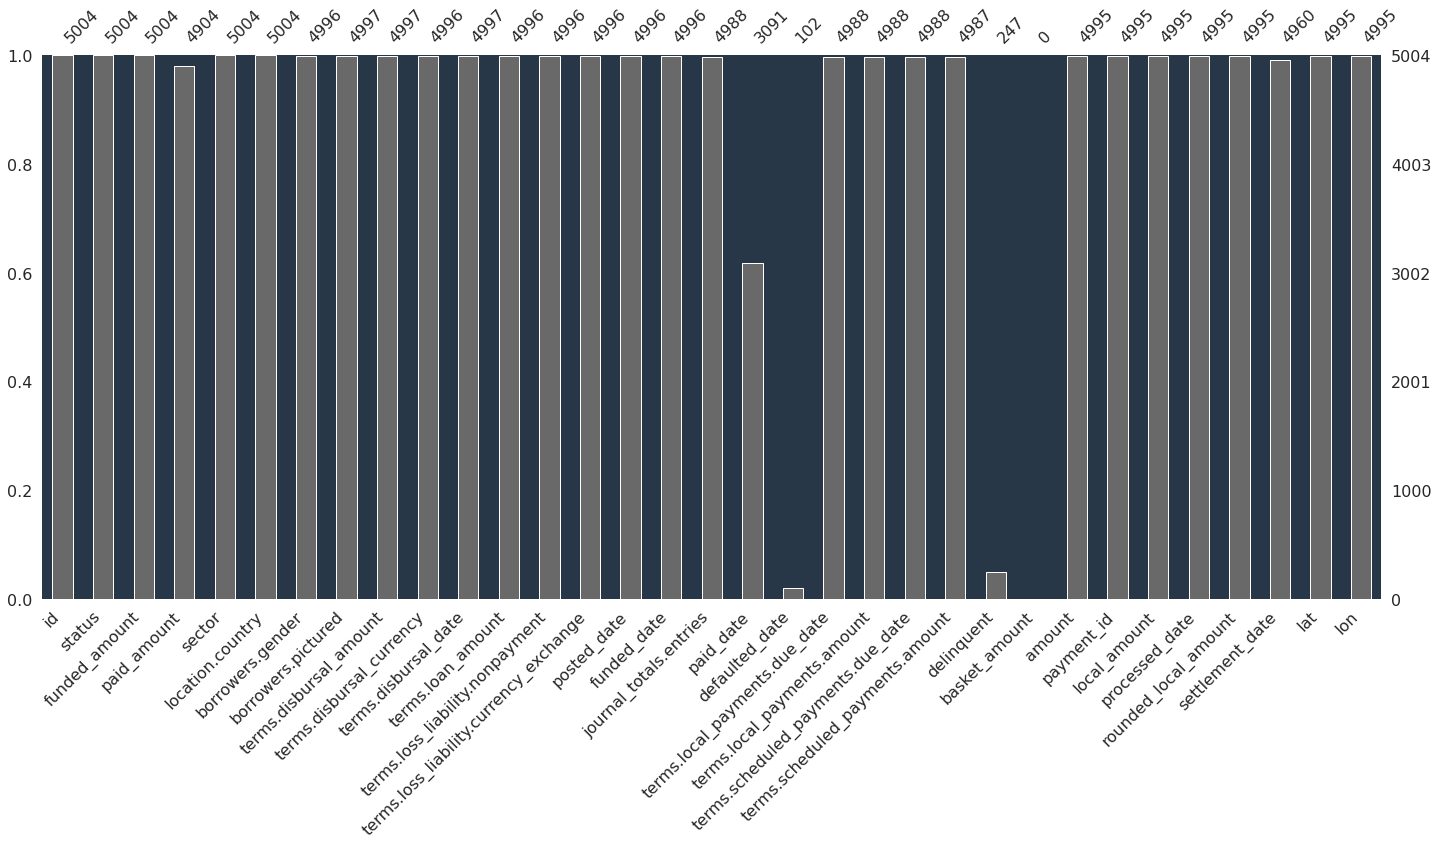

In [81]:
# Missing value of the loan dataset
msno.bar(data)

With thses above graphics, we see that the merging dataset has many missing values. Indeed, the description dataset contribute to reduce the information which are contained in the loan dataset. So, we will use only the loan dataset.

### b) Univariate analysis
In this part we will find out the information behind the variables.
* **Qualitative variable**
  * Loan Status

In [82]:
pd.crosstab(data.status,"freq")

col_0,freq
status,
101,1
F,1
defaulted,100
in_repayment,1818
paid,3084


In [83]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [84]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data = data[data.status != 'in_repayment']
data.shape
conditions = [
    (data.status == 'defaulted'),
    (data.status == 'paid')
]
values = [1,0]

data['target'] = np.select(conditions, values)
pd.crosstab(data.target,"freq")

col_0,freq
target,
0,3084
1,100


* Sector

In [85]:
pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.02
Arts,3.11
Clothing,8.79
Construction,2.42
Education,0.13
Entertainment,0.09
Food,30.50
Health,0.94
Housing,0.82


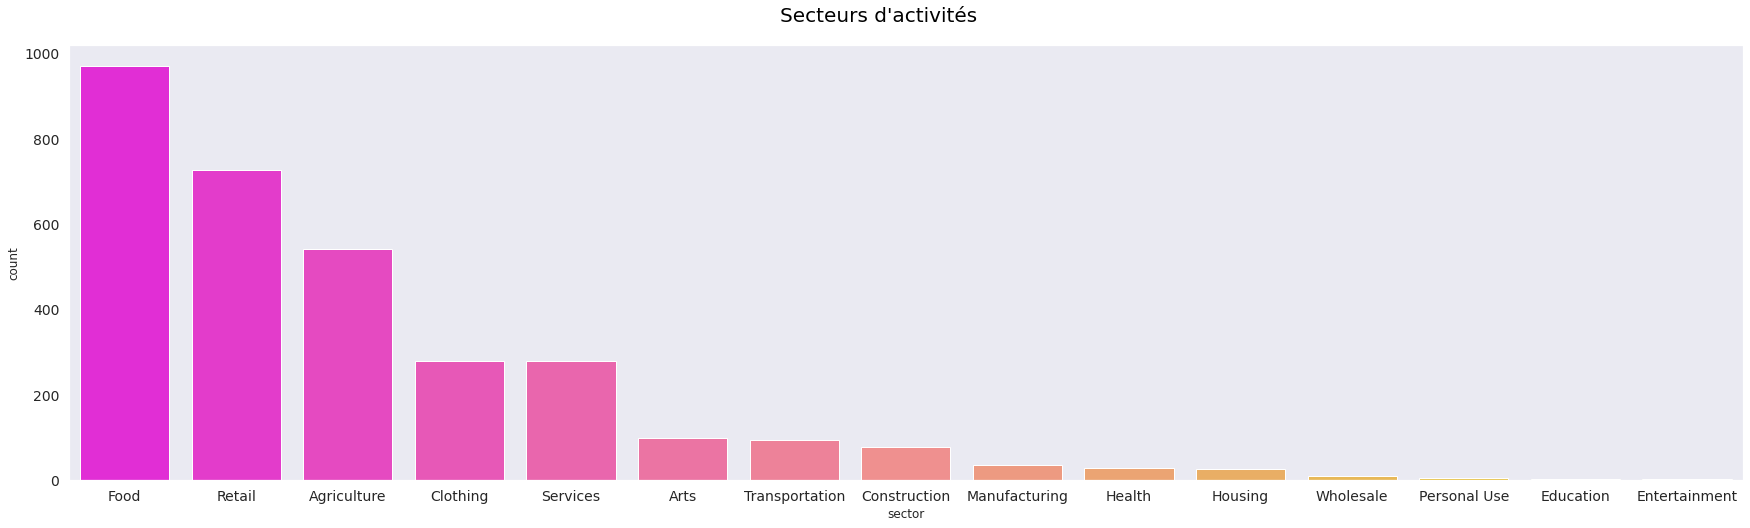

In [86]:
plt.figure(figsize=(30,8))
sns.set(rc={"axes.grid":False,'xtick.labelsize':14,'ytick.labelsize':14})
plt.gcf().text(.5, .93, "Secteurs d'activités", fontsize = 20, color='black' ,ha='center', va='center')
ax = sns.countplot(x=data['sector'] , order =data['sector'].value_counts().index , palette="spring")

plt.show()

In [87]:
Bien_Menage = ['Clothing','Housing','Personnal Use']
autre_secteur = ['Services','Education','Transportation','Arts','Health','Construction','Manufacturing','Entertainment','Wholesale']
conditions = [
    (data.sector == 'Agriculture'),
    (data.sector == 'Food'),
    (data.sector == 'Retail'),
    (data.sector == 'Clothing') | (data.sector == 'Housing') | (data.sector == 'Personal Use'),
    (data.sector == 'Services') | (data.sector == 'Education') | (data.sector == 'Transportation') | (data.sector == 'Arts') | (data.sector == 'Health') | (data.sector == 'Services') | (data.sector == 'Construction') |  (data.sector == 'Manufacturing') | (data.sector == 'Entertainment') | (data.sector == 'Wholesale')
]
values = ['Agriculture','Food','Retail','Bien_Menage','autre_secteur']
data.sector = np.select(conditions, values)

pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.02
Bien_Menage,9.80
Food,30.50
Retail,22.83
autre_secteur,19.85


* Borrower gender

In [88]:
# Unique modalité of this variable
data.rename(columns={'borrowers.gender':'gender'}, inplace = True)
len(pd.unique(data['gender']))

pd.crosstab(data['gender'].isna(),'freq')

col_0,freq
gender,
False,3181
True,3


We have 3 borrowers who do not give the gender.

In [89]:
# Suppression des missings values
data = data.dropna(how='all', subset=['gender'])

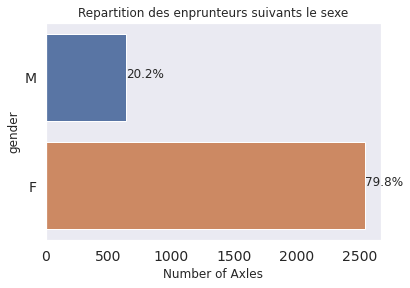

In [90]:
ax = sns.countplot(y="gender", data=data)
plt.title('Repartition des enprunteurs suivants le sexe')
plt.xlabel('Number of Axles')

total = len(data['gender'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Countries repartition

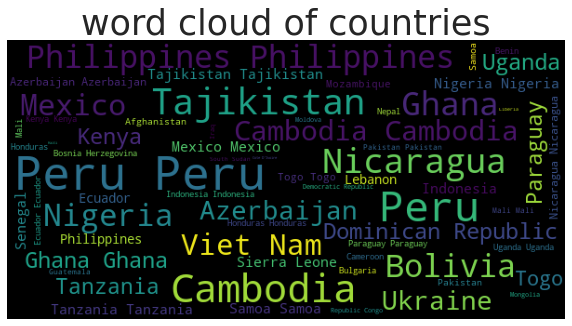

In [91]:
# Wordcloud of the country
data.rename(columns={'location.country':'country_name'}, inplace = True)

names = data["country_name"][~pd.isnull(data["country_name"])]
#print(names)
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(names))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.title("word cloud of countries", fontsize=35)
plt.axis("off")
plt.show() 

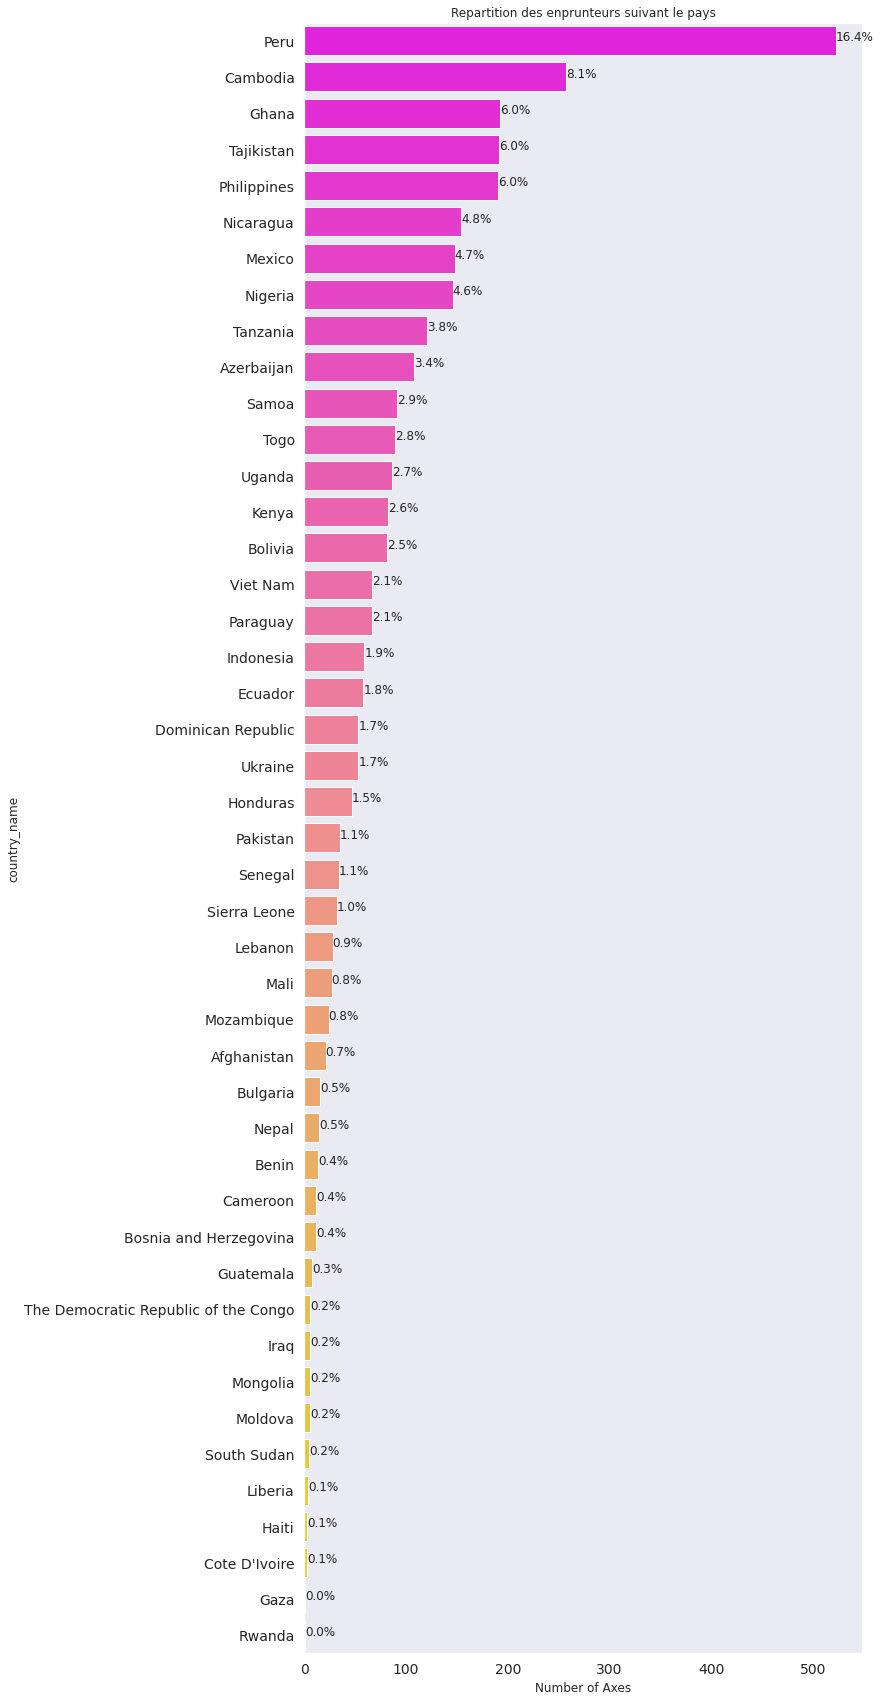

In [92]:
plt.figure(figsize=(10,30))
ax = sns.countplot(y="country_name", data=data, order =data['country_name'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivant le pays')
plt.xlabel('Number of Axes')

total = len(data['country_name'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [93]:
# grouping the country due to their continent
def pays_par_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'

data['CONTINENT'] = data['country_name'].apply(pays_par_continent)

#vérification du rendu :
data['CONTINENT'].unique()

array(['North America', 'Unknown', 'Africa', 'Europe', 'Asia', 'Oceania',
       'South America'], dtype=object)

In [94]:
# We have the modality Unknown which we are going to give the real value
# looking for the country correspond to unknow
data[data['CONTINENT']=='Unknown']['country_name'].unique()

array(['Gaza', 'The Democratic Republic of the Congo', "Cote D'Ivoire"],
      dtype=object)

In [95]:
data.CONTINENT = np.where((data.country_name == 'The Democratic Republic of the Congo') | (data.country_name == "Cote D'Ivoire"),'Africa',data.CONTINENT)
data.CONTINENT = np.where((data.country_name == 'Gaza'),'Asia',data.CONTINENT)

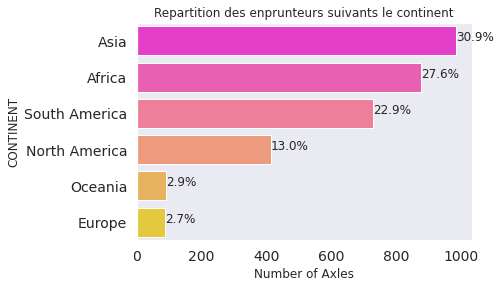

In [96]:
#plt.figure(figsize=(10,30))
ax = sns.countplot(y="CONTINENT", data=data, order =data['CONTINENT'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivants le continent')
plt.xlabel('Number of Axles')

total = len(data['CONTINENT'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Borrower pictured

In [97]:
data.rename(columns={'borrowers.pictured':'borrower_pictured'}, inplace = True)

pd.crosstab(data['borrower_pictured'],'freq').apply(lambda r: 100 * r/len(data), axis=1)

col_0,freq
borrower_pictured,
True,49.984282
FALSE,0.094310
TRUE,49.921408


In [98]:
conditions = [
    (data.borrower_pictured == 'TRUE') | (data.borrower_pictured == 'True'),
    (data.borrower_pictured == 'FALSE')
]
values = ['TRUE','FALSE']

data['borrower_pictured'] = np.select(conditions, values)
pd.crosstab(data['borrower_pictured'],'freq')

col_0,freq
borrower_pictured,
0,1590
FALSE,3
TRUE,1588


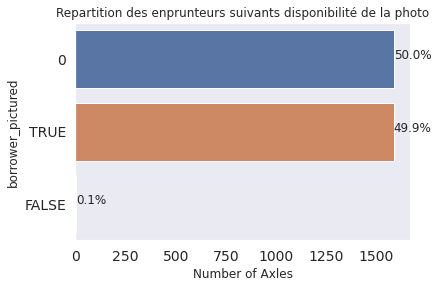

In [99]:
ax = sns.countplot(y="borrower_pictured", data=data)
plt.title('Repartition des enprunteurs suivants disponibilité de la photo')
plt.xlabel('Number of Axles')

total = len(data['borrower_pictured'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Date of payment (funded date, posted date)

In [100]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT'],
      dtype='object')

In [101]:
# Conversion des variables en datetime

data["posted_date"] = pd.to_datetime(data["posted_date"])
data["funded_date"] = pd.to_datetime(data["funded_date"])
data["terms.disbursal_date"] = pd.to_datetime(data["terms.disbursal_date"])
data["settlement_date"] = pd.to_datetime(data["settlement_date"])

data["posted_date"].dt
data["funded_date"].dt
data["terms.disbursal_date"].dt
data["settlement_date"].dt

# Ajout des variables années à notre dataset
data["posted_date"] = data["posted_date"].dt.year
data["funded_date"] = data["funded_date"].dt.year
data["terms.disbursal_date"] = data["terms.disbursal_date"].dt.year
data["settlement_date"] = data["settlement_date"].dt.year

# Définition des variables pour la représentation graphique
df1 = pd.crosstab(data["posted_date"],"freq")
df2 = pd.crosstab(data["funded_date"],"freq")
df3 = pd.crosstab(data["terms.disbursal_date"],"freq")
df4 = pd.crosstab(data["settlement_date"],"freq")

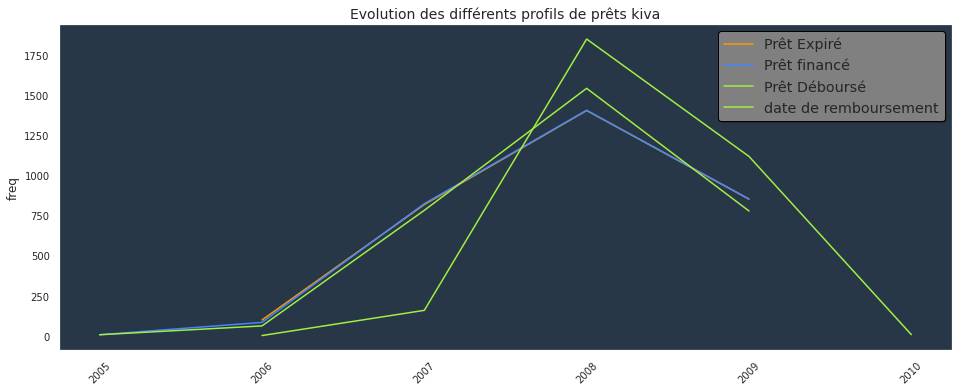

In [102]:
plt.figure(figsize=(16,6))
sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("Evolution des différents profils de prêts kiva",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df1.index.values, y = df1['freq'] , color = '#ff9900' , label= 'Prêt Expiré')
sns.lineplot(x = df2.index.values, y = df2['freq'] , color = '#4586ff' , label = 'Prêt financé')
sns.lineplot(x = df3.index.values, y = df3['freq'] , color = '#a2ef44' , label = 'Prêt Déboursé')
sns.lineplot(x = df4.index.values, y = df4['freq'] , color = '#a2ef44' , label = 'date de remboursement')
plt.legend(facecolor= 'grey' , fontsize='large' , edgecolor = 'black' ,shadow=True) # Legend formatting
plt.show()

* **Quantitative variable**

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3181 non-null   object 
 1   status                                  3181 non-null   object 
 2   funded_amount                           3181 non-null   object 
 3   paid_amount                             3081 non-null   object 
 4   sector                                  3181 non-null   object 
 5   country_name                            3181 non-null   object 
 6   gender                                  3181 non-null   object 
 7   borrower_pictured                       3181 non-null   object 
 8   terms.disbursal_amount                  3181 non-null   object 
 9   terms.disbursal_currency                3181 non-null   object 
 10  terms.disbursal_date                    3181 non-null   int6

In [104]:
data['funded_amount'] = pd.to_numeric(data['funded_amount'], downcast='float')
data['paid_amount'] = pd.to_numeric(data['paid_amount'], downcast='float')

In [105]:
numerical_col = data.select_dtypes(include =["number"]).columns.values
numerical_col

array(['funded_amount', 'paid_amount', 'terms.disbursal_date',
       'terms.loan_amount', 'posted_date', 'funded_date',
       'journal_totals.entries', 'basket_amount', 'amount', 'payment_id',
       'settlement_date', 'lat', 'lon', 'target'], dtype=object)

In [106]:
def Num_info(df, numeric_column):
  """ Fonction qui affiche les infos sur les variables quantitatives
    le nombre de missings et leur pourcentage """
  df_result = pd.DataFrame(columns=["columns","null_values","null_percent"])
    
  df_temp=pd.DataFrame()
  for value in numeric_column:

    df_temp["columns"] = [value]
    df_temp["null_values"] = df[value].isna().sum()
    df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
    df_result = df_result.append(df_temp)
    
  df_result.sort_values("null_values", ascending =False, inplace=True)
  df_result.set_index("columns", inplace=True)
  return df_result

In [107]:
df_num = Num_info(data,numerical_col)
df_num

,null_values,null_percent
columns,,
basket_amount,3181,100.0
paid_amount,100,3.1
settlement_date,35,1.1
funded_amount,0,0.0
terms.disbursal_date,0,0.0
terms.loan_amount,0,0.0
posted_date,0,0.0
funded_date,0,0.0
journal_totals.entries,0,0.0


In [108]:
var_quanti = ['amount','paid_amount','funded_amount','journal_totals.entries']
data[var_quanti].describe()

,amount,paid_amount,funded_amount,journal_totals.entries
count,3181.000000,3081.000000,3181.000000,3181.000000
mean,107.415929,681.986389,680.084900,1.454574
std,142.532848,600.016907,593.962952,0.672619
min,0.080000,25.000000,25.000000,1.000000
25%,42.000000,325.000000,325.000000,1.000000
50%,69.000000,525.000000,525.000000,1.000000
75%,110.000000,900.000000,900.000000,2.000000
max,1818.100000,5000.000000,5000.000000,7.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

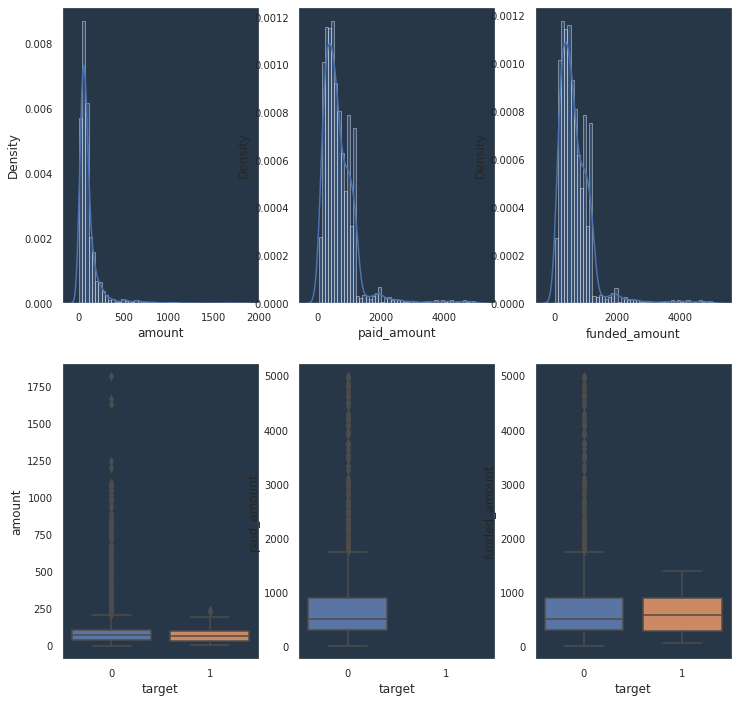

In [109]:
numerical_cols1 = ['amount','paid_amount','funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,3,i)
    sns.distplot(data[col])
    plt.subplot(2,3,3+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

In [110]:
# Remplacement des données 95% percetile value
Q4 = data['paid_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de paid_amount est de : ",len(data[data['paid_amount'] >= Q4]))
data.loc[data['paid_amount'] >= Q4, 'paid_amount'] = Q4 # outlier capping

Q4 = data['funded_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de funded_amount est de :",len(data[data['funded_amount'] >= Q4]))
data.loc[data['funded_amount'] >= Q4, 'funded_amount'] = Q4 # outlier capping

Le nombre total de paid_amount est de :  357
Le nombre total de funded_amount est de : 370


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


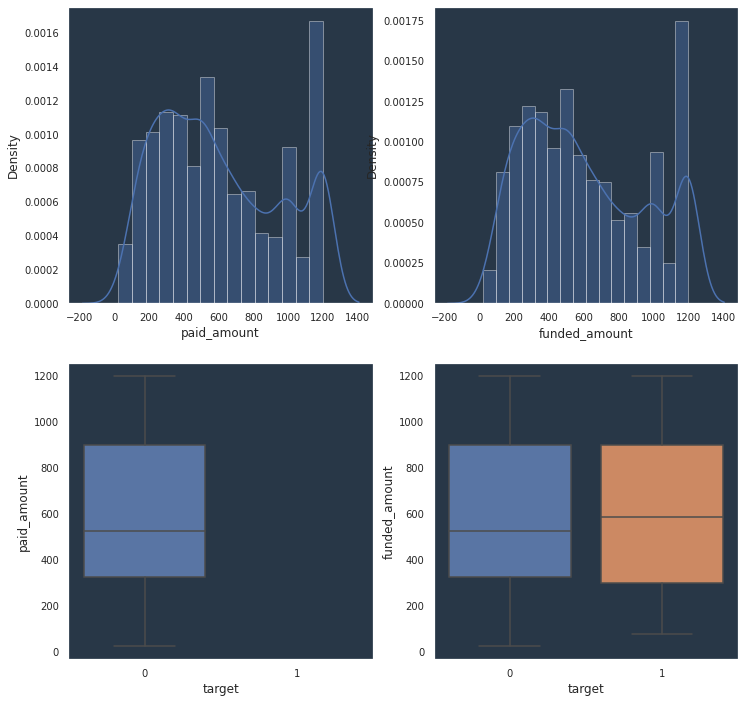

In [111]:
numerical_cols1 = ['paid_amount', 'funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,2,i)
    sns.distplot(data[col])
    plt.subplot(2,2,2+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

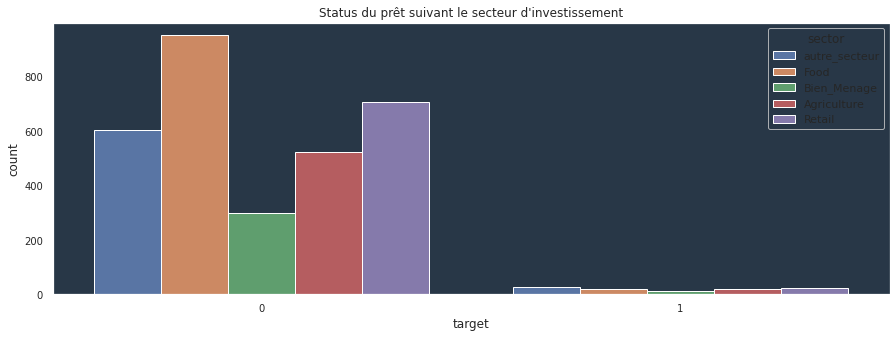

In [112]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="target", hue='sector', data=data).set_title("Status du prêt suivant le secteur d'investissement");

#### - Categorials variables
The aim of this session is to sump up the univariate analysis in term of doing some basics modifications in our previous variables like recode, define a label and so one.

In [113]:
data.sector.value_counts()

Food             970
Retail           727
autre_secteur    632
Agriculture      540
Bien_Menage      312
Name: sector, dtype: int64

In [114]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT'],
      dtype='object')

In [115]:
categorical_var = ['gender','borrower_pictured','terms.loss_liability.nonpayment']
data[categorical_var] = data[categorical_var].astype('category')
data['gender'] = data['gender'].cat.codes
data['borrower_pictured'] = data['borrower_pictured'].cat.codes
data['terms.loss_liability.nonpayment'] = data['terms.loss_liability.nonpayment'].cat.codes

In [116]:
# We can group the sector variable
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
data['sector_cat'] = np.where(data['sector'].isin(others), "Other", data['sector'])

In [117]:
#We can create dummy variables
data = pd.get_dummies(data, columns=['sector_cat','CONTINENT','terms.loss_liability.currency_exchange'], prefix = ['sector','continent','currency_exchange'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3181 non-null   object 
 1   status                             3181 non-null   object 
 2   funded_amount                      3181 non-null   float32
 3   paid_amount                        3081 non-null   float32
 4   sector                             3181 non-null   object 
 5   country_name                       3181 non-null   object 
 6   gender                             3181 non-null   int8   
 7   borrower_pictured                  3181 non-null   int8   
 8   terms.disbursal_amount             3181 non-null   object 
 9   terms.disbursal_currency           3181 non-null   object 
 10  terms.disbursal_date               3181 non-null   int64  
 11  terms.loan_amount                  3181 non-null   float

In [118]:
# Converting amount data
amount_var = ['terms.disbursal_amount','terms.local_payments.amount','terms.scheduled_payments.amount','local_amount','rounded_local_amount']
for var in amount_var :
  data[var] = np.where(data[var].isna(),0.0,data[var])
  data[var]=data[var].str.replace(',', '.')
data[amount_var] = data[amount_var].astype('float')

In [119]:
date_var = ['terms.disbursal_date','paid_date','defaulted_date','terms.local_payments.due_date','terms.scheduled_payments.due_date','processed_date']
data = data.drop(['id','status','terms.disbursal_currency','country_name','sector','delinquent', 'terms.scheduled_payments.amount','rounded_local_amount', 'basket_amount', 'sector_Agriculture', 'continent_Africa','currency_exchange_none'], axis=1)
data = data.drop(date_var, axis=1)
data

,funded_amount,paid_amount,gender,borrower_pictured,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.nonpayment,posted_date,funded_date,journal_totals.entries,terms.local_payments.amount,amount,payment_id,local_amount,settlement_date,lat,lon,target,sector_Bien_Menage,sector_Food,sector_Retail,sector_autre_secteur,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,currency_exchange_partner,currency_exchange_shared
0,500.0,500.0,1,0,500.0,500.0,1,2006,2005,1.0,NaN,50.00,209.0,50.00,2006.0,12.150833,-86.268333,0,0,0,0,1,0,0,1,0,0,0,0
1,600.0,NaN,1,0,600.0,600.0,0,2006,2005,7.0,NaN,50.00,261.0,50.00,NaN,31.284167,34.250833,1,0,0,0,1,1,0,0,0,0,0,0
2,500.0,500.0,0,0,500.0,500.0,1,2006,2005,2.0,NaN,35.00,200.0,35.00,2006.0,14.600000,-87.833333,0,0,1,0,0,0,0,1,0,0,0,0
3,500.0,500.0,0,0,500.0,500.0,1,2006,2005,2.0,NaN,35.00,189.0,35.00,NaN,14.600000,-87.833333,0,0,0,0,1,0,0,1,0,0,0,0
4,575.0,575.0,0,0,575.0,575.0,1,2006,2005,2.0,NaN,114.00,435.0,114.00,2007.0,-0.866667,36.433333,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,150.0,150.0,0,0,7000.0,150.0,1,2009,2009,2.0,368.42,7.89,35990841.0,368.42,2009.0,13.000000,122.000000,0,0,0,1,0,1,0,0,0,0,1,0
4997,350.0,350.0,0,0,50000.0,350.0,1,2009,2009,1.0,6250.00,43.75,44587807.0,6250.00,2009.0,6.583333,3.750000,0,0,1,0,0,0,0,0,0,0,1,0
5000,225.0,225.0,0,0,10000.0,225.0,1,2009,2009,2.0,192.31,28.12,36020263.0,1250.00,2009.0,13.000000,122.000000,0,0,0,0,0,1,0,0,0,0,1,0
5001,75.0,75.0,0,0,3000.0,75.0,1,2009,2009,2.0,120.00,12.05,36020291.0,482.17,2009.0,13.000000,122.000000,0,1,0,0,0,1,0,0,0,0,1,0


> Missing value treatment : with this caption, we have the quick look in the distribution of the missing values in our final dataset.

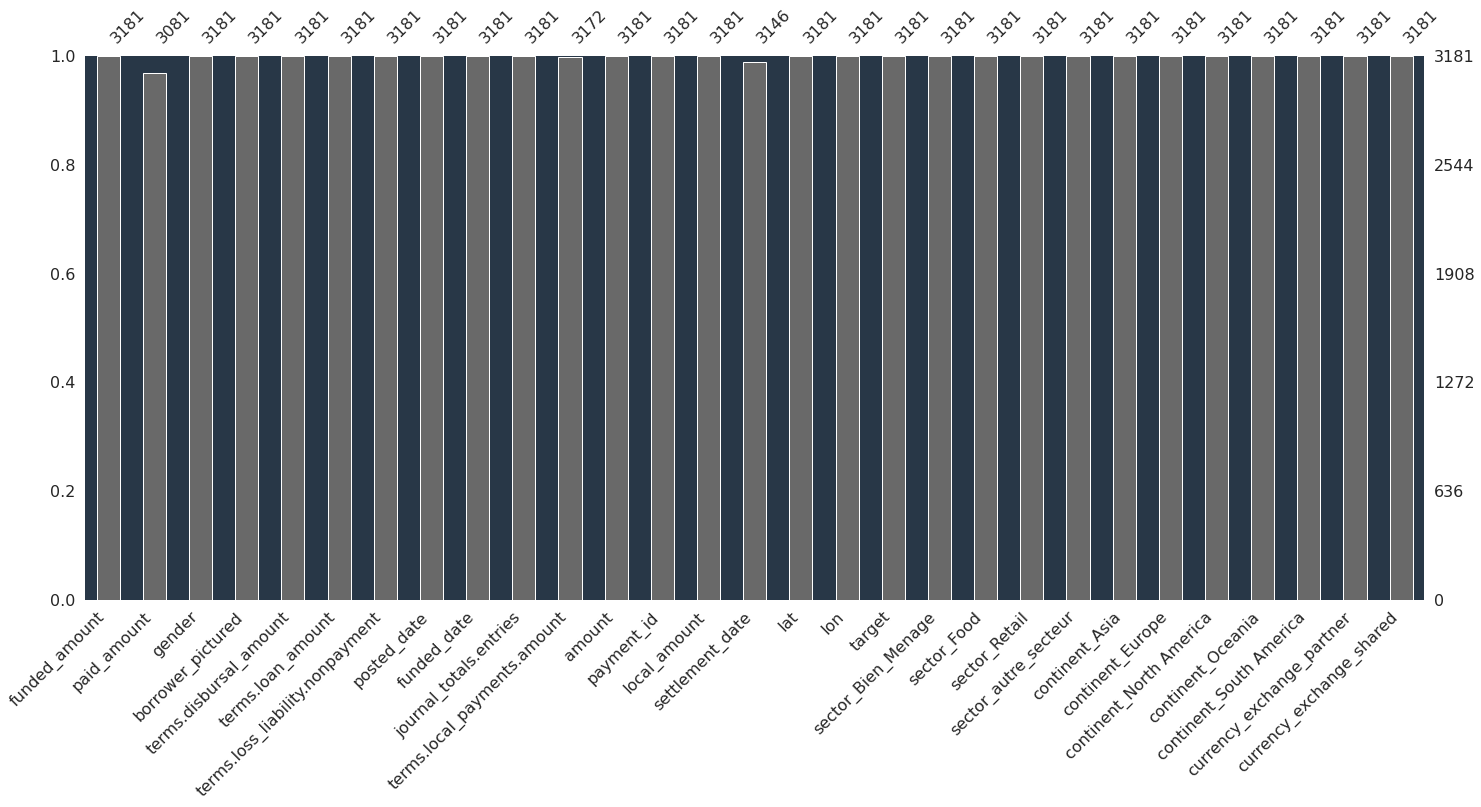

In [120]:
msno.bar(data)

In [121]:
# Imputation of the variable which already contain missing values.
imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(data)
imputed = pd.DataFrame(imputed)
imputed.columns = data.columns
data = imputed

### c) Bivariate analysis

We will do a cross-analysis of the explanatory variables on the target variable. This gives an idea of the effect of borrower characteristics on the default probability.

In [60]:
pd.crosstab(data.target,data['CONTINENT'],margins=True)

KeyError: ignored

In [122]:
pd.crosstab(data.target,data['gender'],margins=True)

gender,0.0,1.0,All
target,,,
0.0,2466,615,3081
1.0,74,26,100
All,2540,641,3181


In [ ]:
pd.crosstab(data.target,data['sector'],margins=True)

In [124]:
pd.crosstab(data.target,data['borrower_pictured'],margins=True)

borrower_pictured,0.0,1.0,2.0,All
target,,,,
0.0,1540,3,1538,3081
1.0,50,0,50,100
All,1590,3,1588,3181


In [125]:
data.groupby(['target']).mean()

,funded_amount,paid_amount,gender,borrower_pictured,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.nonpayment,posted_date,funded_date,journal_totals.entries,terms.local_payments.amount,amount,payment_id,local_amount,settlement_date,lat,lon,sector_Bien_Menage,sector_Food,sector_Retail,sector_autre_secteur,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,currency_exchange_partner,currency_exchange_shared
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,608.089906,608.089906,0.199611,0.999351,539107.84113,681.986368,0.912691,2007.974359,2007.974034,1.457644,66836.250936,108.59184,1.498184e+07,73132.280088,2008.313729,8.327854,-0.362143,0.097371,0.308341,0.228822,0.19604,0.319052,0.028238,0.130153,0.029536,0.228173,0.675105,0.033431
1.0,618.000000,607.200000,0.260000,1.000000,7066.83770,621.500000,0.140000,2007.110000,2007.100000,1.360000,730.311200,71.18610,2.309665e+06,794.441900,2007.854000,2.118508,-6.315159,0.120000,0.200000,0.220000,0.28000,0.010000,0.000000,0.120000,0.000000,0.250000,0.210000,0.000000


### d) Multivariate analysis : Description of the defaulted loan

The goal of this part is to do a multivariate analysis of the features with the intention of highlighting the features that are more likely to predict our target variable. To do this we will use the principal component analysis (PCA). 

In [128]:
#!pip install prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#!pip install prince
import prince
import math as mt
from scipy.stats import chi2
from sklearn.neighbors import KNeighborsClassifier


#### ***Implementation and choice of axis***

In [129]:
data.head()

,funded_amount,paid_amount,gender,borrower_pictured,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.nonpayment,posted_date,funded_date,journal_totals.entries,terms.local_payments.amount,amount,payment_id,local_amount,settlement_date,lat,lon,target,sector_Bien_Menage,sector_Food,sector_Retail,sector_autre_secteur,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,currency_exchange_partner,currency_exchange_shared
0,500.0,500.0,1.0,0.0,500.0,500.0,1.0,2006.0,2005.0,1.0,39.5,50.0,209.0,50.0,2006.0,12.150833,-86.268333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,600.0,545.0,1.0,0.0,600.0,600.0,0.0,2006.0,2005.0,7.0,39.5,50.0,261.0,50.0,2006.6,31.284167,34.250833,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,500.0,500.0,0.0,0.0,500.0,500.0,1.0,2006.0,2005.0,2.0,39.5,35.0,200.0,35.0,2006.0,14.600000,-87.833333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,500.0,500.0,0.0,0.0,500.0,500.0,1.0,2006.0,2005.0,2.0,39.5,35.0,189.0,35.0,2006.6,14.600000,-87.833333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,575.0,575.0,0.0,0.0,575.0,575.0,1.0,2006.0,2005.0,2.0,39.5,114.0,435.0,114.0,2007.0,-0.866667,36.433333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
# Data for PCA
y = data.target
dataPCA = data.drop('target',axis = 1)

# Implementation of PCA
pca = prince.PCA(n_components=10, n_iter=3, rescale_with_mean=True,
   rescale_with_std=True,copy=True,check_input=True,engine='auto', random_state=42)
pca = pca.fit(dataPCA)

# Choice of the axis
pca.explained_inertia_

array([0.1489655 , 0.12662061, 0.10182566, 0.07955601, 0.05672436,
       0.05336063, 0.0502158 , 0.04604947, 0.04099315, 0.04013183])

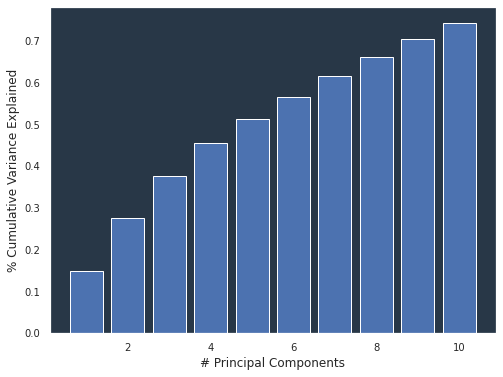

In [131]:
# Calculate cumulative explained variance across all PCs
cum_exp_var = []
var_exp = 0

for i in pca.explained_inertia_:
    var_exp += i
    cum_exp_var.append(var_exp)



# Plot cumulative explained variance for all PCs

fig,ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,11), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [132]:
pca.eigenvalues_

array([4.17103388, 3.54537704, 2.85111855, 2.22756825, 1.58828206,
       1.49409777, 1.40604239, 1.28938513, 1.14780826, 1.12369137])

In [133]:
## KMO index
R= dataPCA.corr()

inv_R=np.linalg.inv(R)
A=np.zeros(shape=(inv_R.shape[0],inv_R.shape[1]))
for i in range(inv_R.shape[0]):
  for j in range(i+1,inv_R.shape[1]):
    A[i,j]= -inv_R[i,j]/np.sqrt(inv_R[i,i]*inv_R[j,j])
    A[j,i]=A[i,j]
R=R.values

kmo_numerateur= np.sum(R**2)-np.sum(np.diag(R**2))
kmo_denominateur=kmo_numerateur + (np.sum(A**2)-np.sum(np.diag(A**2)))
kmo=kmo_numerateur/kmo_denominateur
print("kmo :",round(kmo,ndigits=2))

kmo : 0.42


In [134]:
#  Bartlett test
n=dataPCA.shape[0]
p=dataPCA.shape[1]
khi2=-(n-1-(2*p+5)/6)*mt.log(np.linalg.det(R))
ddl=p*(p-1)/2
p_valeur=chi2.pdf(khi2,ddl)

print(p_valeur < 0.01)

True


***Interpretation of the results***

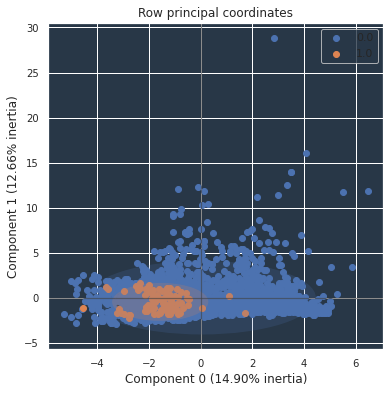

In [135]:
# Correlation
ax = pca.plot_row_coordinates(dataPCA,  ax=None,    figsize=(6, 6),
    x_component=0, y_component=1,labels=None, color_labels=y,ellipse_outline=False,ellipse_fill=True,show_points=True)

In [136]:
pca.column_correlations(dataPCA)

,0,1,2,3,4,5,6,7,8,9
amount,0.102250,0.642065,-0.249513,-0.243307,0.066088,0.093032,-0.006548,-0.013359,0.041314,-0.102522
borrower_pictured,-0.450688,0.084029,-0.035108,0.193680,-0.450125,-0.319473,-0.007214,-0.038740,-0.036074,-0.131680
continent_Asia,0.107329,0.072404,0.839872,-0.044200,0.096634,-0.196248,-0.059446,-0.060950,-0.079435,0.058686
continent_Europe,-0.152966,0.074171,0.128527,-0.231268,-0.210827,0.233543,0.079356,-0.127099,0.469874,-0.105012
continent_North America,-0.220182,-0.125427,-0.174215,-0.070620,-0.194090,0.593643,0.270622,0.331271,-0.392576,-0.028310
continent_Oceania,-0.107363,-0.065393,-0.278683,0.071784,0.095716,0.017948,-0.213868,0.053211,0.108078,0.726684
continent_South America,0.204716,-0.043826,-0.657476,0.132248,0.181547,-0.303458,0.096412,-0.124652,0.162929,-0.368921
currency_exchange_partner,0.408475,0.158516,-0.146163,0.134582,-0.696189,-0.251022,0.035274,0.159805,-0.064474,0.053263
currency_exchange_shared,0.369445,-0.034291,0.023265,-0.123179,0.485197,0.250772,0.017438,-0.210920,0.101960,-0.224304
funded_amount,-0.365662,0.733542,-0.141906,-0.438868,0.006635,-0.091718,-0.117120,-0.033007,-0.055201,0.023694


Text(0.5, 1.0, 'Circle of Correlations')

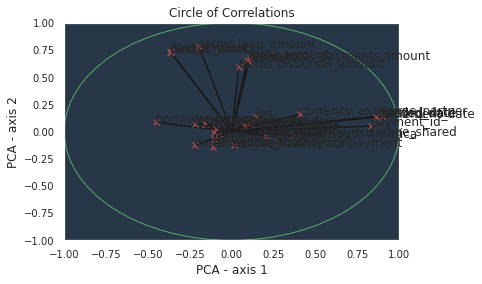

In [137]:
X = pca.column_correlations(dataPCA).loc[:,:2]
plt.Circle((0,0),radius=20, color='g', fill=False)
circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle1)
for idx in range(len(X)):
		x = X[0].values[idx]
		y = X[1].values[idx]
		plt.plot([0.0,x],[0.0,y],'k-')
		plt.plot(x, y, 'rx')
		plt.annotate(X.index[idx], xy=(x,y))
  
plt.xlabel('PCA - axis 1')
plt.ylabel("PCA - axis 2")
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title("Circle of Correlations")

#### ***Classification after the PCA***

# Modelisation
The main target of this session is to use the previous result to build our prediction model. Due to the imbalance of our dataset, we will use some specifics algorithms like **SMOTE** and **Near Miss Algorithm**. We will compare the perfomance both of them to have the best imbalance algorithm for our models. So, we will start for building our imbalance algorithms, and then build our selection model for having the perfomance of our predictions models.
Before starting, we have to sleep our data set into train and test set. The test set, will be use after building the predictions models to evaluate their performance. 


In [138]:
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

logit = LogisticRegression()

In [177]:
# split into 70:30 ration 
Y = data['target']
X = data.drop(['target'], axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(Y_train == 0))) 
print("test set counts of label '1': {}".format(sum(Y_test == 1))) 
print("test set counts of label '0': {}".format(sum(Y_test == 0)))

Before OverSampling, counts of label '1': 68
Before OverSampling, counts of label '0': 2158
test set counts of label '1': 32
test set counts of label '0': 923


### **Imbalance algorithms**

##### 1) SMOTE (Synthetic Minority Oversampling Technique)
This algorithm aims to balance class distribution by randomly increasing minority class examples by replicating them. *SMOTE* generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [178]:
!pip install imblearn
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss 

In [221]:
sm = SMOTE(random_state = 2) 
X_train_sm, y_train_sm = sm.fit_sample(X_train, Y_train.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [189]:
X_train.columns

Index(['paid_amount', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.loan_amount', 'terms.loss_liability.nonpayment', 'posted_date',
       'funded_date', 'journal_totals.entries', 'amount', 'local_amount',
       'settlement_date', 'sector_Bien_Menage', 'sector_Food', 'sector_Retail',
       'sector_autre_secteur', 'continent_Asia', 'continent_Europe',
       'continent_North America', 'continent_Oceania',
       'continent_South America', 'currency_exchange_partner',
       'currency_exchange_shared'],
      dtype='object')

In [193]:
x_train_sm = pd.DataFrame(X_train_sm,columns=X_train.columns.to_list())

In [196]:
y_train_sm = pd.DataFrame(y_train_sm)

In [197]:
x_train_sm.shape,y_train_sm.shape

((4316, 23), (4316, 1))

In [142]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_sm == 0))) 

After OverSampling, the shape of train_X: (4316, 28)
After OverSampling, the shape of train_y: (4316,) 

After OverSampling, counts of label '1': 2158
After OverSampling, counts of label '0': 2158


##### 2) NearMiss Algorithm
aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process.
To prevent problem of information loss in most under-sampling techniques, near-neighbor methods are widely used.

In [143]:
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, Y_train.ravel()) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [144]:
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

After Undersampling, the shape of train_X: (136, 28)
After Undersampling, the shape of train_y: (136,) 

After Undersampling, counts of label '1': 68
After Undersampling, counts of label '0': 68


### **Feature Selection**

There are mainly three major ways to make feature selection :


*   **Filter methods** : considers the relationship between features and the target variable based on a certain metric to compute the importance of features. 
*   **Wrapper methods** : generate models with a subsets of feature and gauge their model performances. It will lead to a set of features which gives the best performance.
*   **Embedded methods** : use some model algorithms to built the feature selection. For instance, Lasso and RF have their own feature selection methods.

##### 1.   Filter methods




In [145]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler

In [146]:
Y = data['target']
X = data.drop(['target','lat', 'lon', 'payment_id'], axis=1)
X_norm = MinMaxScaler().fit_transform(X)

In [ ]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [148]:
### First we define the number of features we want to keep
num_feat = 10

In [149]:
#apply SelectKBest class to extract best features
bestfeatures = SelectKBest(score_func=chi2, k=num_feat)
fit = bestfeatures.fit(X_norm,Y)
chi_support = bestfeatures.get_support()
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_feat,'Score'))  #print num_feat best features

                              Specs      Score
6   terms.loss_liability.nonpayment  65.092491
23        currency_exchange_partner  31.722585
18                   continent_Asia  29.906145
7                       posted_date  12.387610
8                       funded_date   6.277839
15                      sector_Food   3.728286
17             sector_autre_secteur   3.436505
24         currency_exchange_shared   3.343070
21                continent_Oceania   2.953586
19                 continent_Europe   2.823759


In [ ]:
#We verify collinearity between amount variables
amount_columns = data.columns[data.columns.str.contains('amount')]
amount_data = data.filter(items=amount_columns, axis=1)
corrmat = amount_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We remove funded_amount and terms.local_payments.amount due to their strong correlation with another meaningful variables.

In [151]:
# We remove those variables 
data = data.drop(['lat', 'lon', 'payment_id', 'funded_amount', 'terms.local_payments.amount'], axis=1)
Y = data['target']
X = data.drop(['target'], axis=1)
X_norm = MinMaxScaler().fit_transform(X)

In [152]:
fit = bestfeatures.fit(X,Y)
chi_support = bestfeatures.get_support()
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_feat,'Score'))  #print num_feat best features

                              Specs         Score
3            terms.disbursal_amount  5.248435e+07
10                     local_amount  7.152681e+06
9                            amount  1.261641e+03
4                 terms.loan_amount  5.210506e+02
5   terms.loss_liability.nonpayment  6.509249e+01
21        currency_exchange_partner  3.172258e+01
16                   continent_Asia  2.990615e+01
13                      sector_Food  3.728286e+00
15             sector_autre_secteur  3.436505e+00
22         currency_exchange_shared  3.343070e+00


##### 2.   Wrapper methods (Recursive Feature Elimination)




In [153]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feat, step=10, verbose=5)
rfe_selector.fit(X_norm, Y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 23 features.
Fitting estimator with 13 features.
10 selected features


##### 3.   Pipeline methods




In [154]:
##Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, Y,num_feat)
##Logistic Regression
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feat)
embeded_lr_selector.fit(X_norm, Y)
embeded_lr_support = embeded_lr_selector.get_support()
##RF
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feat)
embeded_rf_selector.fit(X, Y)
embeded_rf_support = embeded_rf_selector.get_support()
##LGBM
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feat)
embeded_lgb_selector.fit(X, Y)
embeded_lgb_support = embeded_lgb_selector.get_support()

In [155]:
feature_name = X.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feat)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,terms.loss_liability.nonpayment,True,True,True,True,True,True,6
2,amount,True,True,True,True,True,True,6
3,posted_date,True,False,True,True,True,True,5
4,funded_date,True,False,True,True,True,True,5
5,terms.disbursal_amount,True,True,False,False,True,True,4
6,settlement_date,True,False,True,True,True,False,4
7,currency_exchange_partner,True,True,True,True,False,False,4
8,continent_Asia,True,True,True,True,False,False,4
9,terms.loan_amount,False,True,False,False,True,True,3
10,sector_autre_secteur,True,True,False,False,False,False,2


Finally, we retain variables with at least 4 as score. 

In [156]:
var_retain = feature_selection_df[feature_selection_df['Total']>=4]['Feature']

In [161]:
var_retain = var_retain.to_list()

In [163]:
var_retain

['terms.loss_liability.nonpayment',
 'amount',
 'posted_date',
 'funded_date',
 'terms.disbursal_amount',
 'settlement_date',
 'currency_exchange_partner',
 'continent_Asia']

### Linear regression model

In [203]:
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [199]:
x_train_sm = x_train_sm[var_retain]

In [213]:
# Using RFE to reduce the feature count from 54 to 20
logreg = LogisticRegression()
rfe = RFE(logreg, 20)           
rfe = rfe.fit(x_train_sm, y_train_sm)

#checking the output of RFE
list(zip(x_train_sm.columns, rfe.support_, rfe.ranking_))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[('terms.loss_liability.nonpayment', True, 1),
 ('amount', True, 1),
 ('posted_date', True, 1),
 ('funded_date', True, 1),
 ('terms.disbursal_amount', True, 1),
 ('settlement_date', True, 1),
 ('currency_exchange_partner', True, 1),
 ('continent_Asia', True, 1)]

In [215]:
x_train_sm = sm.add_constant(x_train_sm)
logm = sm.GLM(np.array(y_train_sm),(sm.add_constant(x_train_sm)), family = sm.families.Binomial()) 
res = logm.fit()
res.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4316
Model:                            GLM   Df Residuals:                     4307
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 10 Feb 2021   Deviance:                          nan
Time:                        21:59:24   Pearson chi2:                 3.77e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            3977.9171    328.124     12.123      0.000    3334.807    4621.027
terms.loss_liability.nonpayment    -5.4590      0.200    -27.311      0.000      -5.851      -5.067
amount                             -0.0072      0.001     -6.977      0.000      -0.009      -0.005
posted_date                        -2.3976      0.654     -3.666      0.000      -3.679      -1.116
funded_date                         1.1749      0.646      1.819      0.069      -0.091       2.441
terms.disbursal_amount          -1.021e-05   1.24e-06     -8.212      0.000   -1.27e-05   -7.78e-06
settlement_date                    -0.7571      0.190     -3.977      0.000      -1.130      -0.384
currency_exchange_partner           2.6705      0.242     11.037      0.000       2.196       3.145
continent_Asia                    -39.8620   2.54e+06  -1.57e-05      1.000   -4.97e+06    4.97e+06
===================================================================================================
"""

In [216]:
# Getting the predicted values on the train set
y_train_pred = res.predict(x_train_sm)
y_train_pred[:10]

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0    4.219355e-02
1    9.775320e-02
2    5.098259e-19
3    1.705630e-19
4    9.540259e-01
5    2.670825e-20
6    5.926297e-02
7    3.765545e-31
8    9.958919e-01
9    2.890390e-28
dtype: float64

In [217]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([4.21935498e-02, 9.77532037e-02, 5.09825861e-19, 1.70563037e-19,
       9.54025851e-01, 2.67082456e-20, 5.92629720e-02, 3.76554501e-31,
       9.95891906e-01, 2.89038961e-28])

In [235]:
# Creating a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'target':y_train_sm.ravel(), 'target_prob':y_train_pred})
y_train_pred_final['Borrower ID'] = y_train.index
y_train_pred_final.head()

,target,target_prob,Borrower ID
0,0.0,4.219355e-02,0
1,0.0,9.775320e-02,1
2,0.0,5.098259e-19,2
3,0.0,1.705630e-19,3
4,1.0,9.540259e-01,4


In [236]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.target_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,target,target_prob,Borrower ID,predicted
0,0.0,4.219355e-02,0,0
1,0.0,9.775320e-02,1,0
2,0.0,5.098259e-19,2,0
3,0.0,1.705630e-19,3,0
4,1.0,9.540259e-01,4,1


In [237]:
#Finding Optimal Cutoff Point
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.target_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,target,target_prob,Borrower ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,4.219355e-02,0,0,1,0,0,0,0,0,0,0,0,0
1,0.0,9.775320e-02,1,0,1,0,0,0,0,0,0,0,0,0
2,0.0,5.098259e-19,2,0,1,0,0,0,0,0,0,0,0,0
3,0.0,1.705630e-19,3,0,1,0,0,0,0,0,0,0,0,0
4,1.0,9.540259e-01,4,1,1,1,1,1,1,1,1,1,1,1


In [238]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci','Precision','Recall'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final['target'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    prec, rec, thresholds = precision_recall_curve(y_train_pred_final['target'], y_train_pred_final[i])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, prec[1], rec[1]]
cutoff_df

,prob,accuracy,sensi,speci,Precision,Recall
0.0,0.0,0.500232,1.000000,0.000463,1.000000,0.000000
0.1,0.1,0.832715,0.995366,0.670065,0.751049,0.995366
0.2,0.2,0.865385,0.967099,0.763670,0.803620,0.967099
0.3,0.3,0.886469,0.930028,0.842910,0.855499,0.930028
0.4,0.4,0.904310,0.888786,0.919833,0.917264,0.888786
0.5,0.5,0.911029,0.883225,0.938832,0.935231,0.883225
0.6,0.6,0.917053,0.879981,0.954124,0.950450,0.879981
0.7,0.7,0.917285,0.871177,0.963392,0.959673,0.871177
0.8,0.8,0.912187,0.859129,0.965246,0.961120,0.859129
0.9,0.9,0.884615,0.796571,0.972660,0.966817,0.796571


<Figure size 1296x576 with 0 Axes>

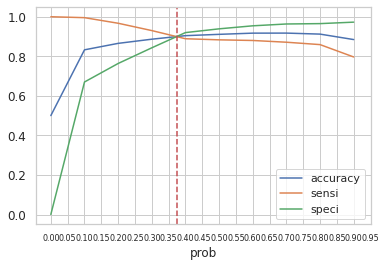

In [243]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
plt.figure(figsize=(18,8))
sns.set_style("whitegrid")
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0,1,step=0.05),size=8)
plt.axvline(x=0.375, color='r', linestyle='--') # additing axline
plt.yticks(size=12)
plt.show()

In [244]:
y_train_pred_final['final_predicted_1'] = y_train_pred_final['target_prob'].map( lambda x: 1 if x > 0.49 else 0)
#y_train_pred_final.drop([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],axis = 1, inplace = True) # deleting the unnecessary columns
y_train_pred_final.head()

,target,target_prob,Borrower ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted_1
0,0.0,4.219355e-02,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,9.775320e-02,1,0,1,0,0,0,0,0,0,0,0,0,0
2,0.0,5.098259e-19,2,0,1,0,0,0,0,0,0,0,0,0,0
3,0.0,1.705630e-19,3,0,1,0,0,0,0,0,0,0,0,0,0
4,1.0,9.540259e-01,4,1,1,1,1,1,1,1,1,1,1,1,1


In [245]:
# Let's assign Lead_score for the leads in Train Data Set
y_train_pred_final['lead_score_1']=(y_train_pred_final['target_prob']*100).astype("int64")
y_train_pred_final.sort_values(by='target_prob',ascending=False)

,target,target_prob,Borrower ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted_1,lead_score_1
97,1.0,9.972306e-01,97,1,1,1,1,1,1,1,1,1,1,1,1,99
4188,1.0,9.971169e-01,4188,1,1,1,1,1,1,1,1,1,1,1,1,99
3644,1.0,9.971050e-01,3644,1,1,1,1,1,1,1,1,1,1,1,1,99
3420,1.0,9.970934e-01,3420,1,1,1,1,1,1,1,1,1,1,1,1,99
3356,1.0,9.967910e-01,3356,1,1,1,1,1,1,1,1,1,1,1,1,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0.0,8.949739e-103,510,0,1,0,0,0,0,0,0,0,0,0,0,0
1387,0.0,6.353395e-111,1387,0,1,0,0,0,0,0,0,0,0,0,0,0
1978,0.0,1.088920e-122,1978,0,1,0,0,0,0,0,0,0,0,0,0,0
217,0.0,2.044328e-172,217,0,1,0,0,0,0,0,0,0,0,0,0,0


In [248]:
# Create a matrix to Print the Accuracy, Sensitivity and Specificity
def lg_metrics(confusion_matrix):

  TN =confusion_matrix[0,0]
  TP =confusion_matrix[1,1]
  FP =confusion_matrix[0,1]
  FN =confusion_matrix[1,0]
  accuracy = (TP+TN)/(TP+TN+FP+FN)
  speci = TN/(TN+FP)
  sensi = TP/(TP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  TPR = TP/(TP + FN)
  TNR = TN/(TN + FP)
  FPR = FP/(TN + FP)
  FNR = FN/(TP + FN)
  pos_pred_val = TP /(TP+FP)
  neg_pred_val = TN /(TN+FN)
  
  print ("Model Accuracy value is              : ", round(accuracy*100,2),"%")
  print ("Model Sensitivity value is           : ", round(sensi*100,2),"%")
  print ("Model Specificity value is           : ", round(speci*100,2),"%")
  print ("Model Precision value is             : ", round(precision*100,2),"%")
  print ("Model Recall value is                : ", round(recall*100,2),"%")
  print ("Model True Positive Rate (TPR)       : ", round(TPR*100,2),"%")
  print ("Model False Positive Rate (FPR)      : ", round(FPR*100,2),"%")
  print ("Model Poitive Prediction Value is    : ", round(pos_pred_val*100,2),"%")
  print ("Model Negative Prediction value is   : ", round(neg_pred_val*100,2),"%")

Text(0.5, 257.44, 'Predicted label')

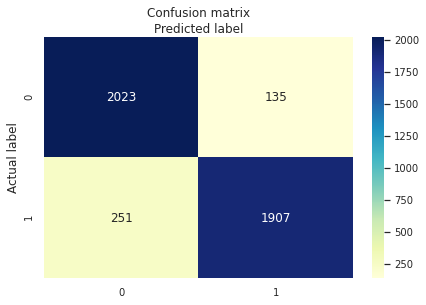

In [246]:
## Confusion matrix 
cnf_matrix = metrics.confusion_matrix(y_train_pred_final['target'], y_train_pred_final['final_predicted_1'])
#cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:, np.newaxis]

class_names=['defaut','succès'] # Nom des classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [249]:
conf_matrix = confusion_matrix(y_train_pred_final['target'], y_train_pred_final['final_predicted_1'])

lg_metrics(conf_matrix)

Model Accuracy value is              :  91.06 %
Model Sensitivity value is           :  88.37 %
Model Specificity value is           :  93.74 %
Model Precision value is             :  93.39 %
Model Recall value is                :  88.37 %
Model True Positive Rate (TPR)       :  88.37 %
Model False Positive Rate (FPR)      :  6.26 %
Model Poitive Prediction Value is    :  93.39 %
Model Negative Prediction value is   :  88.96 %


In [250]:
# Classification Record : Precision, Recall and F1 Score
print( metrics.classification_report(y_train_pred_final['target'], y_train_pred_final['final_predicted_1']) )

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      2158
         1.0       0.93      0.88      0.91      2158

    accuracy                           0.91      4316
   macro avg       0.91      0.91      0.91      4316
weighted avg       0.91      0.91      0.91      4316



In [251]:
print("F1 Score: {}".format(f1_score(y_train_pred_final['target'], y_train_pred_final['final_predicted_1'])))

F1 Score: 0.908095238095238
